In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_ctcf(ctcf_path, chrom, start):
    ctcf_all = pickle.load(open(ctcf_path, 'rb'))
    ctcf = ctcf_all['chr{}'.format(chrom)].toarray()[0][start*200: (start+700)*200]

    return ctcf


def load_atac(atac_path, chrom, start):
    atac_all = pickle.load(open(atac_path, 'rb'))
    atac = atac_all['chr{}'.format(chrom)].flatten()[start*200: (start+700)*200]

    return atac


def load_scatac(scatac_path, metacell_path, chrom, start):
    scatac_pre = pickle.load(open(scatac_path, 'rb'))['chr{}'.format(chrom)]
    metacell = csr_matrix(pd.read_csv(metacell_path, index_col=0).values)
    tmp = torch.tensor((metacell * scatac_pre)[:, start*20:(start+700)*20].toarray()).T

    size, eps = tmp.shape[1], 1e-8
    one, zero = torch.tensor(1.0), torch.tensor(0.0)
    lrg = torch.where(tmp>0, one, zero)
    eql = torch.where(tmp==0, one, zero)
    num, denom = lrg @ lrg.T, size - eql @ eql.T
    scatac = torch.div(num, torch.max(denom, eps * torch.ones_like(denom)))
    scatac[scatac != scatac] = 0

    scatac = scatac.reshape(
        scatac.shape[0]//20, 20, -1
    ).mean(axis=1).reshape(
        -1, scatac.shape[1]//20, 20
    ).mean(axis=2)

    return scatac


def load_multiome(input_dir, ct, chrom, start, genome='mm10'):
    ctcf_path = osp.join(input_dir, 'dna', '{}_ctcf_motif_score.p'.format(genome))
    atac_path = osp.join(input_dir, 'atac', '{}_tile_pbulk_50bp_dict.p'.format(ct))
    scatac_path = osp.join(input_dir, 'atac', '{}_tile_500bp_dict.p'.format(ct))
    metacell_path = osp.join(input_dir, 'atac', '{}_metacell_mask.csv'.format(ct))

    ctcf = load_ctcf(ctcf_path, chrom, start)
    atac = load_atac(atac_path, chrom, start)
    scatac = load_scatac(scatac_path, metacell_path, chrom, start)

    return ctcf, atac, scatac


def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [3]:
input_dir = '/data/leslie/suny4/processed_input'
ct1, ct2 = 'mycGCB_db_arid1a_2_gcb_nothelp_sample', 'mycGCB_db_arid1a_2_gcb_nothelp'
out_dir = './../testfile/chr1_significant_genes.csv'
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
res = pd.read_csv(out_dir)
chrom = 1
row = res.iloc[0]

In [4]:
row

chrom                            chr1
start                       138825186
end                         138848577
gene_id         ENSMUSG00000019230.14
gene_type              protein_coding
gene_status                     KNOWN
gene_name                        Lhx9
level                               2
havana_gene      OTTMUSG00000022572.7
significance                 0.252158
Name: 0, dtype: object

In [5]:
%%time

start = int(max(row['start']//1e4-400, 0))
locstart, locend = row['start']/1e4 - start, row['end']/1e4 - start
gene = row['gene_name']

start = 3300
locstart, locend = 3700, 3750
gene = 'TEST'

ctcf, atac1, scatac1 = load_multiome(input_dir, ct1, chrom, start)
_, atac2, scatac2 = load_multiome(input_dir, ct2, chrom, start)
pred1, pred2 = load_pred(pred_dir, ct1, chrom, avg_stripe=True), load_pred(pred_dir, ct2, chrom, avg_stripe=True)

CPU times: user 41 s, sys: 12.4 s, total: 53.4 s
Wall time: 39.8 s


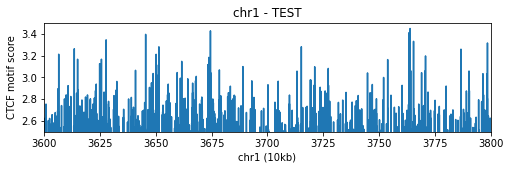

In [6]:
def plot_ctcf(ctcf, chrom, start, gene, locstart, locend):
    fig, ax = plt.subplots(figsize=(8,2))
    ax.plot(ctcf)
    plt.xlim(300*200, 500*200)
    plt.ylim(2.5, 3.5)
    tickloc = ax.get_xticks()
    ticklabel = np.linspace(start+300, start+500, num=len(tickloc), dtype=int).tolist()
    plt.xticks(tickloc, ticklabel)
    plt.title('chr{} - {}'.format(chrom, gene), fontsize=12)
    plt.xlabel('chr{} (10kb)'.format(chrom))
    plt.ylabel('CTCF motif score')
    
    plt.axvspan(locstart*200, locend*200, alpha=0.3, color='red')
    plt.show()
    

plot_ctcf(ctcf, chrom, start, gene, locstart, locend)

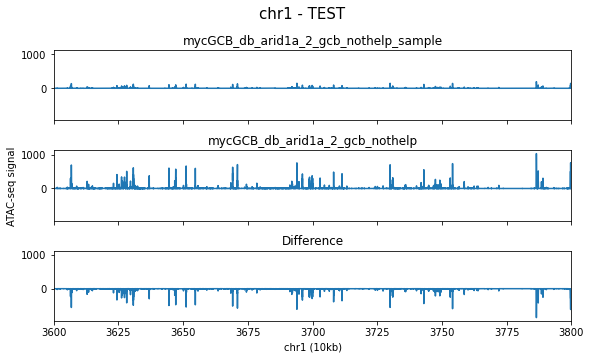

In [7]:
def plot_atac(atac1, atac2, ct1, ct2, chrom, start, gene, locstart, locend):
    plt.rcParams['figure.figsize'] = 8, 5
    plt.rcParams['figure.autolayout'] = False
    
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
    fig.suptitle('chr{} - {}'.format(chrom, gene), fontsize=15)
    fig.tight_layout(rect=[0.01, 0.03, 1, 4.5/5], h_pad=2)
    
    atacs = [atac1, atac2, atac1-atac2]
    cts = [ct1, ct2, 'Difference']
    for i in range(3):
        ax, atac, ct = axs[i], atacs[i], cts[i]
        ax.plot(atac)
        ax.title.set_text(ct)
        ax.set_xlim(300*200, 500*200)
        ax.set_xticklabels(np.linspace(start+300, start+500, num=len(ax.get_xticks()), dtype=int))
        ax.axvspan(locstart*200, locend*200, alpha=0.3, color='red')
    
    axs[1].set_ylabel('ATAC-seq signal')
    plt.xlabel('chr{} (10kb)'.format(chrom))
    plt.show()

plot_atac(atac1, atac2, ct1, ct2, chrom, start, gene, locstart, locend)

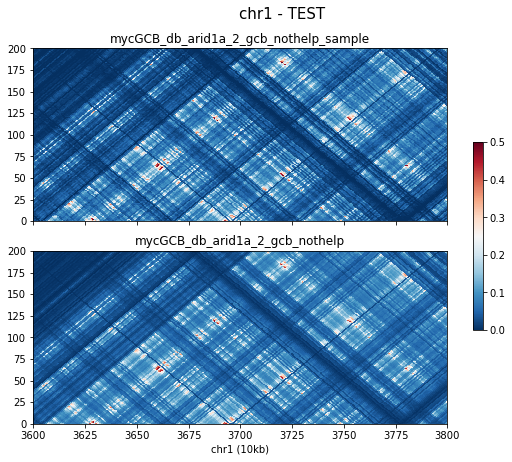

In [10]:
def rotate_coord(n):
    tmp = np.array(list(itertools.product(range(n,-1,-1),range(0,n+1,1))))
    tmp[:, [0, 1]] = tmp[:, [1, 0]]
    A = tmp.dot(np.array([[1, 0.5], [-1, 0.5]]))
    
    return A


def plot_scatac(scatac1, scatac2, ct1, ct2, chrom, start, gene, locstart, locend):
    plt.rcParams['figure.figsize'] = 8, 6.5
    plt.rcParams['figure.autolayout'] = False

    fig, axs = plt.subplots(2, 1, sharex=True)
    fig.suptitle('chr{} - {}'.format(chrom, gene), fontsize=15)
    fig.tight_layout(rect=[0.01, 0.03, 1, 6/6.5], h_pad=2)
    
    vmax, vmin = 0.5, 0
    scatacs = [scatac1, scatac2]
    cts = [ct1, ct2]
    
    for i in range(2):
        ax, scatac, ct = axs[i], scatacs[i], cts[i]
        n = scatac.shape[0]
        A = rotate_coord(n)
        img = ax.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                            np.flipud(scatac), cmap='RdBu_r', vmax=vmax, vmin=vmin)
        ax.title.set_text(ct)
        ax.set_xlim(300, 500)
        ax.set_ylim(0, 200)
        ax.set_xticklabels(np.linspace(start+300, start+500, num=len(ax.get_xticks()), dtype=int))
        
        x = np.arange(300, 500)
        y1, y2 = np.absolute(2*x-2*locstart), np.absolute(2*x-2*locend)
        ax.plot(x, y1, color='magenta', alpha=0.3)
        ax.plot(x, y2, color='magenta', alpha=0.3)
    
    fig.colorbar(img, ax=axs, shrink=1/2)
    plt.xlabel('chr{} (10kb)'.format(chrom))
    plt.show()

plot_scatac(scatac1, scatac2, ct1, ct2, chrom, start, gene, locstart, locend)

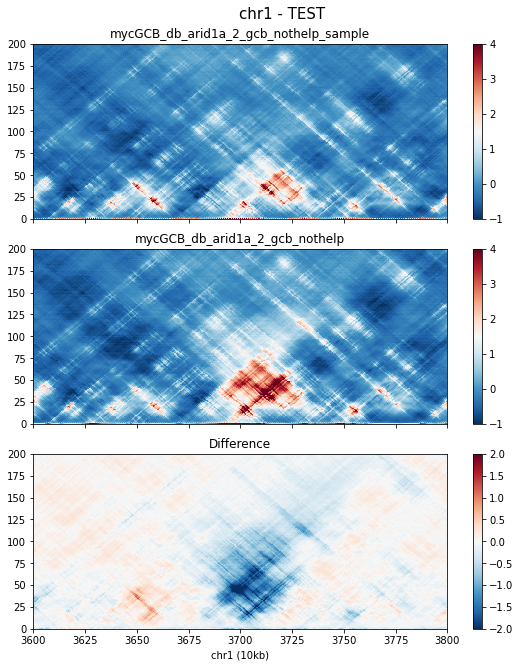

In [11]:
def plot_pred(predmat1, predmat2, ct1, ct2, chrom, start, gene, locstart, locend):
    plt.rcParams['figure.figsize'] = 8, 9.5
    plt.rcParams['figure.autolayout'] = False

    fig, axs = plt.subplots(3, 1, sharex=True)
    fig.suptitle('chr{} - {}'.format(chrom, gene), fontsize=15)
    fig.tight_layout(rect=[0.01, 0.03, 1, 9/9.5], h_pad=2)
    
    vmaxs, vmins = [4, 4, 2], [-1, -1, -2]
    pred1 = np.triu(predmat1[start:start+700, start:start+700])
    pred2 = np.triu(predmat2[start:start+700, start:start+700])
    preds = [pred1, pred2, pred1-pred2]
    cts = [ct1, ct2, 'Difference']
    
    for i in range(3):
        ax, pred, ct = axs[i], preds[i], cts[i]
        n = pred.shape[0]
        A = rotate_coord(n)
        img = ax.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                            np.flipud(pred), cmap='RdBu_r', vmax=vmaxs[i], vmin=vmins[i])
        ax.title.set_text(ct)
        ax.set_xlim(300, 500)
        ax.set_ylim(0, 200)
        ax.set_xticklabels(np.linspace(start+300, start+500, num=len(ax.get_xticks()), dtype=int))
        
        x = np.arange(300, 500)
        y1, y2 = np.absolute(2*x-2*locstart), np.absolute(2*x-2*locend)
        ax.plot(x, y1, color='magenta', alpha=0.3)
        ax.plot(x, y2, color='magenta', alpha=0.3)
        plt.colorbar(img, ax=ax)
        
    plt.xlabel('chr{} (10kb)'.format(chrom))
    plt.show()

plot_pred(pred1, pred2, ct1, ct2, chrom, start, gene, locstart, locend)

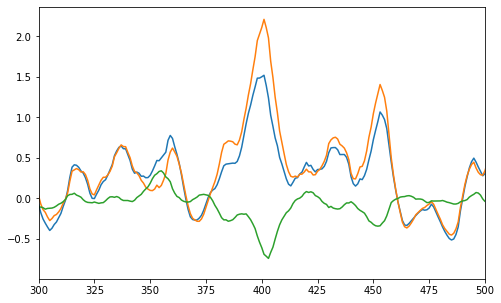

In [12]:
def topdom(pred_mat, window_size=10, cutoff=0):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal

signal1 = topdom(pred1[start:start+700, start:start+700], cutoff=None)
signal2 = topdom(pred2[start:start+700, start:start+700], cutoff=None)
diff = signal1 - signal2
plt.figure(figsize=(8,5))
plt.plot(signal1, label=ct1)
plt.plot(signal2, label=ct2)
plt.plot(diff, label='diff')
plt.xlim(300, 500)
plt.show()